In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [2]:
class Component:
    
    @property
    def parent(self):
        return self._parent

    @parent.setter
    def parent(self, parent):
        self._parent = parent

    def is_composite(self):
        """
        You can provide a method that lets the client code figure out whether a
        component can bear children.
        """

        return False

    def operation(self):
        """
        The base Component may implement some default behavior or leave it to
        concrete classes (by declaring the method containing the behavior as
        "abstract").
        """

        pass

In [3]:
class Model(Component):
    def __init__(self):
        self.time = None # a variable to connect
        self.variables = []
        self.equations = []
        self.parameters = []
    
    def Variable(self, *args, **kwargs):
        variable = Variable(*args, **kwargs)
        self.variables.append(variable)
        setattr(self, variable.name, variable)
        
        return variable
    
    def DerivativeVar(self, variable_name):
        self.Variable(name = 'deriv_' + variable_name)
        self.t0 = 0.0
        variable = getattr(self, variable_name)
        setattr(self, variable_name + '__OLD', variable.get_value())
        
        def backward_euler(m):
            dydt = getattr(m, 'deriv_' + variable_name)()
            y = getattr(m, variable_name)()
            y0 = getattr(m, variable_name + '__OLD')
            time = m.time()
            t0 = m.t0
            return dydt - (y-y0)/(time-t0)
        
        self.Equation(backward_euler) # Backward euler finite diff
        
        derivativevar = getattr(self, 'deriv_' + variable_name)
        
        return derivativevar
    
    def Parameter(self, *args, **kwargs):
        param = Variable(*args, **kwargs)
        self.parameters.append(param)
        setattr(self, param.name, param)
        
        return param
    
    def Equation(self, callable_obj):
        self.equations.append(callable_obj)
        
    def update_states(self):
        attrs = [a for a in dir(self) if a.endswith('__OLD')]
        for attr in attrs:
            y0_value = getattr(self, attr.split('__OLD')[0])()
            setattr(self, attr, y0_value) # self.y0 = self.y()
        
        self.t0 = self.time()

    def set_time_variable(self, time_variable):
        self.time = time_variable
            
    def is_composite(self):
        return False
    
    def update_variables(self, X):
        X1 = X[:len(self.variables)]
        for i, variable in enumerate(self.variables):
            variable.set_value(X1[i])
        X = X[len(self.variables):]
        return X
            
    def residuals(self):
        resid = []
        for equation in self.equations:
            resid.append( equation(self) )
            
        return resid

In [4]:
class Composite(Component):
    """
    The Composite class represents the complex components that may have
    children. Usually, the Composite objects delegate the actual work to their
    children and then "sum-up" the result.
    """

    def __init__(self) -> None:
        self._children = []
        self.num_variables = 0
        self.num_equations = 0

    """
    A composite object can add or remove other components (both simple or
    complex) to or from its child list.
    """
    @property
    def variables(self):
        variables = []
        for child in self._children:
            variables.extend( child.variables )
        
        return variables
    
    def add(self, component):
        self._children.append(component)
        component.parent = self
        
        self.num_variables, self.num_equations = self.update_num_vars_eqs()
        

    def remove(self, component):
        self._children.remove(component)
        component.parent = None
        self.num_variables = self.update_num_variables()
        self.num_equations = self.update_num_equations()
        
    def update_num_vars_eqs(self):
        num_variables = 0
        num_equations = 0
        for child in self._children:
            if child.is_composite():
                num_variables, num_equations = child.update_num_vars_eqs()
            else:
                num_variables += len(child.variables)
                num_equations += len(child.equations)
        
        return num_variables, num_equations
                

    def is_composite(self):
        return True
    
    def update_states(self):
        for child in self._children:
            child.update_states()
    
    def set_time_variable(self, time_variable):
        for child in self._children:
            child.set_time_variable(time_variable)
        
    def update_variables(self, X):
        for child in self._children:
            X = child.update_variables(X)
        
        return X
    
    def residuals(self):
        resid = []
        for child in self._children:
            resid.extend( child.residuals() )
        
        return resid
            
    def compute(self, X):
        """
        The Composite executes its primary logic in a particular way. It
        traverses recursively through all its children, collecting and summing
        their results. Since the composite's children pass these calls to their
        children and so forth, the whole object tree is traversed as a result.
        """
        
        self.update_variables(X)
        resid = self.residuals()
        
        return resid
    
    def solve(self):
        
        XGuess = np.ones(self.num_variables)
        root = fsolve(self.compute, XGuess)
        
        return root
        

In [5]:
class Variable:
    def __init__(self, name='', initial_value=0.0):
        self.value = initial_value
        self.name = name
    
    def set_value(self, value):
        self.value = value
        
    def get_value(self):
        return self.value
        
    def __call__(self):
        return self.value

In [6]:
class Simulator:
    def __init__(self, composite):
        self.composite = composite
        self.clock = Clock(0.0)
        self.composite.add(self.clock)
        
    def simulate(self,time_values):
        
        self.composite.set_time_variable(self.clock.time) # set the time variable for all elements
        
        timesteps = [time_values[0]]
        results = {var.name: [var()] for var in self.composite.variables}

        for curr_time in time_values[1:]:
            self.clock.time.set_value(curr_time)

            root = self.composite.solve()
            self.composite.update_states()

            timesteps.append(self.clock.time())
            for var in self.composite.variables:
                results[var.name].append( var() )
            
        return timesteps, results

In [7]:
class Clock(Model):
    def __init__(self, initial_time):
        super().__init__()
        self.Parameter('time', initial_time)

class Integrator(Model):
    def __init__(self, state_name='y', initial_value=0.0, ):
        super().__init__()
        self.Variable(state_name, initial_value)
        self.DerivativeVar(state_name)
        
class ODEset(Model):
    def __init__(self, state_name='y', equation_obj=lambda m: 0):
        super().__init__()
        # setattr(self, state_name, None)
        # setattr(self, state_name, None)
        # self.y = None
        # self.dydt = None
        
        self.Equation(equation_obj)

# Basic Problems

In [8]:
class SysLinearEq(Model):
    def __init__(self):
        super().__init__()
        
        x = self.Variable('x1')
        y = self.Variable('y1')
        self.Equation(lambda m: 3*x() + 2*y() -1)
        self.Equation(lambda m: x() + 2*y() - 0)

equation_set = SysLinearEq()
model = Composite()
model.add(equation_set)
model.solve()

array([ 0.5 , -0.25])

In [9]:
class SysLinearEq(Model):
    def __init__(self):
        super().__init__()
        
        x = [self.Variable('x'+str(i)) for i in range(2)]
        self.Equation(lambda m: 3*x[0]() + 2*x[1]() -1)
        self.Equation(lambda m: x[0]() + 2*x[1]() - 0)

equation_set = SysLinearEq()
model = Composite()
model.add(equation_set)
model.solve()

array([ 0.5 , -0.25])

In [10]:
class Eq1(Model):
    def __init__(self):
        super().__init__()
        
        x = self.Variable('x')
        self.y = None
        self.Equation(lambda m: 3*x() + 2*m.y() -1)
        

class Eq2(Model):
    def __init__(self):
        super().__init__()
        
        self.x = None
        y = self.Variable('y')
        self.Equation(lambda m: m.x() + 2*y() - 0)
        

eq1 = Eq1()
eq2 = Eq2()
eq1.y = eq2.y
eq2.x = eq1.x
system = Composite()
system.add(eq1)
system.add(eq2)
system_higher = Composite()
system_higher.add(system)

system_higher.solve()

array([ 0.5 , -0.25])

In [11]:
class SysNonLinearEq(Model):
    def __init__(self):
        super().__init__()
        
        z1 = self.Variable('x')
        z2 = self.Variable('y')
        self.Equation(lambda m: z1() + 2*z2() - 0)
        self.Equation(lambda m: z1()**2 + z2()**2 - 1)
equation_set = SysNonLinearEq()
system = Composite()
system.add(equation_set)
system.solve()

array([ 0.89442719, -0.4472136 ])

$$
k\frac{dy}{dt} = -ty
$$

$$
k\frac{dy}{y} = -tdt
$$

$$
k\ln{y} = -\frac{t^2}{2} + C
$$

$$
\ln{y} = -\frac{t^2}{2k} + C
$$

$$
y = C\exp{-\frac{t^2}{2k}}
$$

$$
y = 5\exp{-\frac{t^2}{2k}}
$$

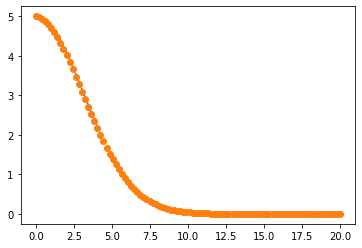

In [12]:
k = 10.0
y0 = 5.0
t0 = 0.0

class ODEset(Model):
    def __init__(self):
        super().__init__()
        
        self.Variable('y', 5.0)
        self.DerivativeVar('y')
        self.Equation(lambda m: k*m.deriv_y() + m.time()*m.y())
        
ode_set = ODEset()

# set the derivative and state on the ODE according the integrator
system = Composite()
system.add(ode_set)

t_values = np.linspace(0,20,100)
sim = Simulator(system)
timesteps, results = sim.simulate(t_values)
# compare with analytical solution
# y = 5exp(-t**2/2k)

y_true = lambda t: 5* np.exp(-t**2/(2*k))
    
plt.plot(timesteps,y_true(np.array(timesteps)),'--')
plt.plot(timesteps,results['y'],'o');

# One Gravity Drained Tank with 2 inflows (TODO MULTIPLE COMPONENTS (x1, x2, etc))
https://jckantor.github.io/CBE30338/02.03-Blending-Tank-Simulation.html

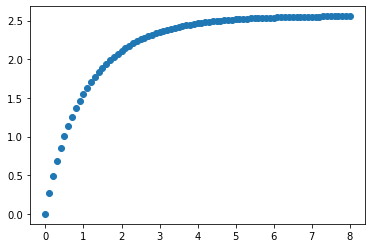

In [26]:
## TODO multiple components
AREA = 0.2
CV = 0.5
RHO = 1000

h0 = 0.0
x0 = 1

F = 0.4
z = 1

t0 = 0
dt = 0.1
tf = 8.0

class FlowSource(Model):
    def __init__(self, name, mass_inflow_func=lambda t: 0.0, composition_func=lambda t: [1.0]):
        super().__init__()
        self.F = self.Variable(name + '_flowrate', mass_inflow_func(0.0))
        n_components = len(composition_func(0.0))
        self.x = [self.Variable(name + '_composition' + str(i), composition_func(0.0)) for i in range(n_components)]
        self.h = self.Parameter(name + '_head', 0.0)
        
        self.Equation( lambda m: self.F() - mass_inflow_func(m.time())) # overall mass balance
        for i in range(n_components):
            self.Equation( lambda m: self.x[i]() - composition_func(m.time())[i]) # overall mass balance
        
        #self.Equation( lambda m: m.dWidt() - (m.F()*RHO*m.z() - m.L()*RHO*m.x())) # per component mass balance
        
class Reservoir(Model):
    def __init__(self, name, n_components=1, initial_mass=0.0):
        super().__init__()
        self.F = self.Variable(name + '_inflow')
        self.z = [self.Variable(name + '_z' + str(i)) for i in range(n_components)]
        
        self.L = self.Variable(name + '_outflow')
        
        self.x = [self.Variable(name + '_x' + str(i)) for i in range(n_components)]
        self.dxdt = [self.DerivativeVar(name + '_x' + str(i)) for i in range(n_components)]
        #self.Wi = [self.Variable(name + '_W' + str(i)) for i in range(n_components)]
        #self.dWidt = [self.DerivativeVar(name + '_W' + str(i)) for i in range(n_components)]
        
        self.W = self.Variable(name + '_W')
        self.dWdt = self.DerivativeVar(name + '_W')
        
        self.h = self.Variable(name + '_h')
        self.P = self.Variable(name + '_P')
        self.Pout = self.Variable(name + '_Pout')
        
        def overall_mass_balance(m):
            return m.dWdt() - (m.F()*RHO - m.L()*RHO)
        
        def component_mass_balance(m,i):
            return m.dxdt[i]() - 1/m.W()*(m.F()*(m.z[i]() - m.x[i]())) 
        
        '''
        def component_fraction_constraint(m,i):
            return m.Wi[i]() - m.x[i]()*m.Wtot()
        
                            
        def total_fraction_constraint(m):
            return sum([var() for var in m.x]) - 1
        '''
        
        def height_constraint(m):
            return m.h() - m.W()/(RHO*AREA)
                            
        def bottom_pressure_constraint(m):
            return m.P() - RHO*9.81*m.h()
                            
        def outlet_pressure_constraint(m):
            return m.P() - m.Pout()
                            
        self.Equation( overall_mass_balance )
        for i in range(n_components):
            self.Equation( lambda m: component_mass_balance(m,i) )
        #self.Equation( total_fraction_constraint )
        self.Equation( height_constraint )
        self.Equation( bottom_pressure_constraint)
        self.Equation( outlet_pressure_constraint )
        
    def input_process_stream(self, flow_objs):
        
        def total_flowrate(m):
            F_total = sum([flow_obj.F() for flow_obj in flow_objs])
            return F_total - self.F()
        
        def total_composition(m,i):
            F_total = sum([flow_obj.F() for flow_obj in flow_objs])
            x_total = sum([flow_obj.F()*flow_obj.x[i]() for flow_obj in flow_objs])/F_total        
            return x_total - self.z[i]()
        
        self.Equation(total_flowrate)
        for i in range(len(flow_objs[0].x)):
            self.Equation(lambda m: total_composition(m,i) )
        
    def output_process_stream(self, flow_objs):
        
        def total_flowrate(m):
            F_total = sum([obj.F() for obj in flow_objs])
            return F_total - self.L()
        
        self.Equation(total_flowrate)
        for flow_obj in flow_objs:
            self.Equation(lambda m: flow_obj.h() - self.h())
            for i in range(len(flow_obj.x)):
                self.Equation(lambda m: flow_obj.x[i]() - self.x[i]())
            
        
class FlowRelease(Model):
    def __init__(self, name, n_components):
        super().__init__()
        self.F = self.Variable(name + '_flowrate')
        self.x = [self.Variable(name + '_x' + str(i)) for i in range(n_components)]
        self.h = self.Variable(name + '_head')
        
        self.Equation( lambda m: self.F() - CV*np.sqrt(np.clip(m.h(), 0.0, None))) # outlet flow
        
class FlowControllable(Model):
    def __init__(self, name, n_components, value=0.0):
        super().__init__()
        self.F = self.Variable(name + '_flowrate')
        self.x = [self.Variable(name + '_x' + str(i)) for i in range(n_components)]
        self.h = self.Variable(name + '_head')
        
        self.Equation( lambda m: self.F() - value) # outlet flow
        

inflow = FlowSource('inflow', mass_inflow_func=lambda t: 0.4, composition_func=lambda t: [1.0])
inflow2 = FlowSource('inflow2', mass_inflow_func=lambda t: 0.4, composition_func=lambda t: [1.0])
tank1 = Reservoir('tank1', n_components=1)
release = FlowRelease('release', n_components=1)
tank1.input_process_stream([inflow, inflow2])
tank1.output_process_stream([release])

system = Composite()
system.add(inflow)
system.add(inflow2)
system.add(tank1)
system.add(release)

t_values = np.linspace(0,8,81)
sim = Simulator(system)
timesteps, results = sim.simulate(t_values)
    
plt.plot(timesteps,results['tank1_h'],'o')

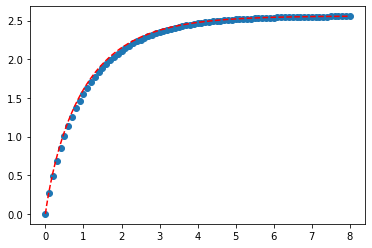

In [27]:
from scipy.integrate import odeint

# 2. Fix parameter values
A = 0.2
Cv = 0.5
qin = 0.4

# 3. Write a function to evaluate RHS of the differential equations
def deriv(X,t):
    h1 = X
    dh1 = (qin + qin - Cv*np.sqrt(h1))/A
    return dh1

# 4. Choose initial conditions and time grid
IC = 0
t = np.linspace(0,8,500)

# 5. Perform the simulation by numerical solution of the differential equations
sol = odeint(deriv,IC,t)

# 6. Prepare visualizations and post-processing
plt.plot(timesteps,results['tank1_h'],'o')
plt.plot(t,sol,'--r');

# Two Gravity Drained Tanks

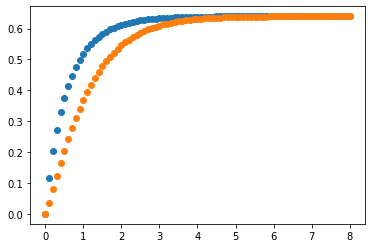

In [28]:
AREA = 0.2
CV = 0.5
RHO = 1000

h0 = 0.0
x0 = 1

F = 0.4
z = 1

t0 = 0
dt = 0.1
tf = 8.0

inflow = FlowSource('inflow', mass_inflow_func=lambda t: 0.4, composition_func=lambda t: [1.0])
tank1 = Reservoir('tank1', n_components=1)
tank2 = Reservoir('tank2', n_components=1)
release1 = FlowRelease('release1', n_components=1)
release2 = FlowRelease('release2', n_components=1)

tank1.input_process_stream([inflow])
tank1.output_process_stream([release1])

tank2.input_process_stream([release1])
tank2.output_process_stream([release2])

system = Composite()
system.add(inflow)
system.add(tank1)
system.add(tank2)
system.add(release1)
system.add(release2)

t_values = np.linspace(0,8,81)
sim = Simulator(system)
timesteps, results = sim.simulate(t_values)
    
plt.plot(timesteps,results['tank1_h'],'o')
plt.plot(timesteps,results['tank2_h'],'o')

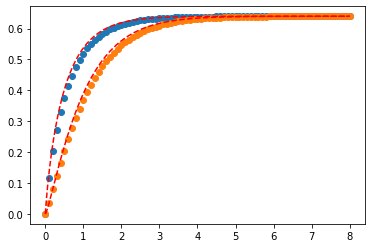

In [29]:
from scipy.integrate import odeint

# 2. Fix parameter values
A = 0.2
Cv = 0.5
qin = 0.4

# 3. Write a function to evaluate RHS of the differential equations
def deriv(X,t):
    h1,h2 = X
    dh1 = (qin - Cv*np.sqrt(h1))/A
    dh2 =  (Cv*np.sqrt(h1) - Cv*np.sqrt(h2))/A 
    return [dh1,dh2]

# 4. Choose initial conditions and time grid
IC = [0,0]
t = np.linspace(0,8,500)

# 5. Perform the simulation by numerical solution of the differential equations
sol = odeint(deriv,IC,t)

# 6. Prepare visualizations and post-processing
plt.plot(timesteps,results['tank1_h'],'o')
plt.plot(timesteps,results['tank2_h'],'o')
plt.plot(t,sol,'--r');


# Complete recyle of 2nd tank into 1st tank

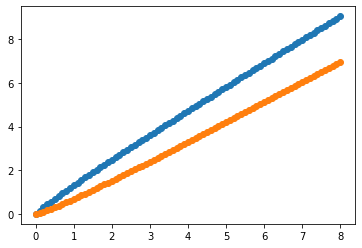

In [30]:
AREA = 0.2
CV = 0.5
RHO = 1000

h0 = 0.0
x0 = 1

F = 0.4
z = 1

t0 = 0
dt = 0.1
tf = 8.0

inflow = FlowSource('inflow', mass_inflow_func=lambda t: 0.4, composition_func=lambda t: [1.0])
tank1 = Reservoir('tank1', n_components=1)
tank2 = Reservoir('tank2', n_components=1)
release1 = FlowRelease('release1', n_components=1)
release2 = FlowRelease('release2', n_components=1)

tank1.input_process_stream([inflow, release2])
tank1.output_process_stream([release1])

tank2.input_process_stream([release1])
tank2.output_process_stream([release2])

system = Composite()
system.add(inflow)
system.add(tank1)
system.add(tank2)
system.add(release1)
system.add(release2)

t_values = np.linspace(0,8,81)
sim = Simulator(system)
timesteps, results = sim.simulate(t_values)
    
plt.plot(timesteps,results['tank1_h'],'o')
plt.plot(timesteps,results['tank2_h'],'o')

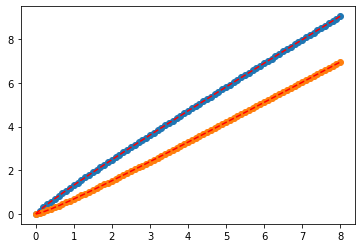

In [31]:
from scipy.integrate import odeint

# 2. Fix parameter values
A = 0.2
Cv = 0.5
qin = 0.4

# 3. Write a function to evaluate RHS of the differential equations
def deriv(X,t):
    h1,h2 = X
    dh1 = (qin - Cv*np.sqrt(h1) + Cv*np.sqrt(h2))/A
    dh2 =  (Cv*np.sqrt(h1) - Cv*np.sqrt(h2))/A 
    return [dh1,dh2]

# 4. Choose initial conditions and time grid
IC = [0,0]
t = np.linspace(0,8,500)

# 5. Perform the simulation by numerical solution of the differential equations
sol = odeint(deriv,IC,t)

# 6. Prepare visualizations and post-processing
plt.plot(timesteps,results['tank1_h'],'o')
plt.plot(timesteps,results['tank2_h'],'o')
plt.plot(t,sol,'--r');


# Blending tank simulation - 1 component
Based on https://jckantor.github.io/CBE30338/02.03-Blending-Tank-Simulation.html

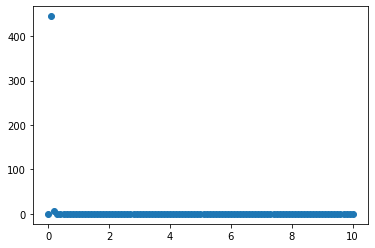

In [34]:
rho = 900.0  # density, kg/m**3

w1 = lambda t: 500.0   # stream 1, kg/min
w2 = lambda t: 200.0   # stream 2, kg/min
w =  700.0   # set outflow equal to sum of inflows

x1 = lambda t: [0.4]     # composition stream 1, mass fraction
x2 = lambda t: [0.75]    # composition stream 2, mass fraction

stream1 = FlowSource('inflow1',mass_inflow_func=w1, composition_func=x1)
stream2 = FlowSource('inflow2',w2, x2)
stream3 = FlowControllable('outflow',n_components=1, value = w)

tank1 = Reservoir('tank1', n_components=1, initial_mass=2.0)

tank1.input_process_stream([stream1, stream2])
tank1.output_process_stream([stream3])

system = Composite()
system.add(stream1)
system.add(stream2)
system.add(stream3)

system.add(tank1)


t_values = np.linspace(0,10,101)
sim = Simulator(system)
timesteps, results = sim.simulate(t_values)
    
plt.plot(timesteps,results['tank1_x0'],'o')

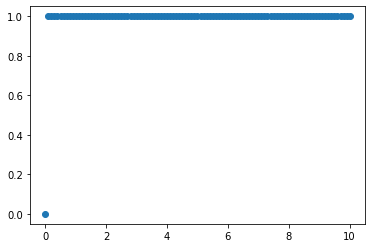

In [35]:
plt.plot(timesteps,results['tank1_W'],'o')